In [80]:
import pandas as pd
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from upsetplot import UpSet, from_contents

In [81]:

def plot_distribution(df, label_column='label', data_column='value'):
    """
    Creates a distribution plot using Seaborn for a Pandas DataFrame with a label column.
    
    Args:
    - df: Pandas DataFrame with a label column and numerical data.
    - label_column: Name of the column containing the labels.
    - data_column: Name of the column containing the data to plot.
    """
    # Get the unique labels in the label column
    labels = df[label_column].unique()
    
    # Set the figure size
    plt.figure(figsize=(10, 5))
    
    # Loop through the labels and create a distribution plot for each one
    for label in labels:
        label_data = df[df[label_column] == label]
        sns.kdeplot(label_data[data_column], label=label, shade=True)
        
    # Add axis labels and title
    plt.xlabel(data_column.capitalize())
    plt.ylabel('Density')
    plt.title(f'Distribution of {data_column.capitalize()} by {label_column.capitalize()}')
    
    # Add a legend
    plt.legend(labels)
    
    # Show the plot
    plt.show()


This noteboke describe the process of creating the all peak file for extracting the AF of variant which can be found in one of the ATAC intervals from gnomAD <br>

I am using the following files 
- hATAC - hATAC_Dec_05_22.csv 
- mATAC - mm10_to_hg38_processed_11_12_22.csv (renamed to 'mm10_hg38_cm_result.csv')
- hATAC & mATAC - mATAC_hATAC_Dec_12_22.xlsx



In [82]:
hATAC = pd.read_csv('data/hATAC_Dec_05_22.csv', index_col=0)
hATAC.columns = ['CHROM', 'FROM','TO','ID']
hATAC.CHROM = 'chr' + hATAC.CHROM
mATAC = pd.read_csv('data/mm10_hg38_cm_result.csv', index_col=0)
mATAC.columns = ['CHROM', 'FROM','TO', 'start_idx','end_idx','ID','length']
mATAC_hATAC = pd.read_excel('data/mATAC_hATAC_Dec_12_22.xlsx', index_col=0, engine='openpyxl')

there are 3 types of intervals:
1. only found in human
2. only found in mouse
3. have intersection, therfore can be found in both

to get 1 & 2 we cna look for id's of intervals of hATA/mATAC which can not be found in the intersection (hATAC & mATAC) <br>


In [102]:
only_human = hATAC[~hATAC.ID.isin(mATAC_hATAC.hATAC_id)]
only_human['label'] = 'human'
only_mouse = mATAC[~mATAC.ID.isin(mATAC_hATAC.mATAC_id)]
only_mouse['label'] = 'mouse'
print(f'there are {only_human.shape[0]:,} unique intervals for the hATAC data')
print(f'there are {only_mouse.shape[0]:,} unique intervals for the mATAC data')

there are 15,938 unique intervals for the hATAC data
there are 149,676 unique intervals for the mATAC data


Type 3, intervals with intersection, are all intervals in the hATAC & mATAC file. <br> for them, we decided to take the minimum start point and the maximal end point between the intersected intervals.

In [84]:
func = lambda row : pd.Series({'CHROM':'chr' + row.chrom,
                              'FROM':min([row.hATAC_start, row.mATAC_start]),
                              'TO' :max([row.hATAC_end, row.mATAC_end]),
                              'ID' : row.new_id})
both = mATAC_hATAC.apply(func,axis=1)
# 

In [95]:
both = both.groupby(['CHROM','FROM','TO']).ID.sum().reset_index()
both['label'] = 'both'

Now we will create  a single dataframe which contains all the intervals, and is sorted by chromosom and positions

In [103]:
combined_interval_df = pd.concat([only_human,only_mouse,both]).iloc[:,:4] # dropping the original mouse interval id

In [97]:

# # sorting the df
combined_interval_df = combined_interval_df.sort_values(['CHROM','FROM'])
combined_interval_df['length'] = combined_interval_df.TO - combined_interval_df.FROM

# summary

In [101]:
print(f'The combined peak table contains {combined_interval_df.shape[0]:,} intervals')
print(f'{only_human.shape[0]:,} found unique in the hATAC')
print(f'{only_mouse.shape[0]:,} found unique in the mATAC')
print(f'{both.shape[0]:,} found in both')
print(f'there are total {only_human.shape[0] + only_mouse.shape[0] + both.shape[0]:,} intervals')

The combined peak table contains 193,680 intervals
15,938 found unique in the hATAC
149,676 found unique in the mATAC
28,066 found in both
there are total 193,680 intervals


# sanity check
Here I check if the full interval list was sent into the bcftools pipeline <br>
in order to do so - I concat the frame i did above with the dataframe which was sent to the pipeline. <br>
then I'll remove all duplicates. If the frame after the removal have rows - it means they are missing from the frame above OR they werent included in the pipeline. <br>
If it happenes, I'll act accordignly

In [ ]:
cur_peak = pd.read_csv('data/peak_bcftools_format.tsv', sep='\t',names=['CHROM','FROM','TO'])
pd.concat([cur_peak,combined_interval_df[['CHROM','FROM','TO']]]).drop_duplicates(keep=False)

luckly the table is empty, hence all intervals were included in the pipeline

# vizualization

In [77]:

plot_df = pd.concat([only_human,only_mouse,both]).iloc[:,:5].reset_index(drop=True)
plot_df['length'] = plot_df.TO - plot_df.FROM

The plot below show's the length distribution of each ATAC result & the common intervals

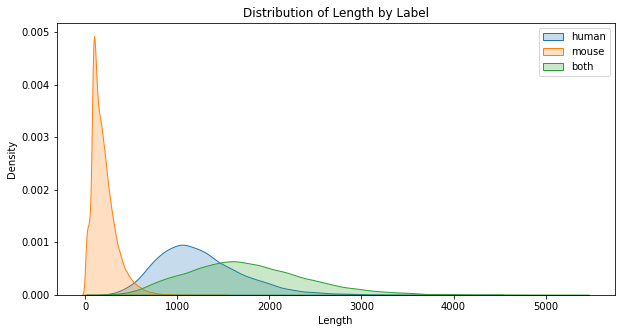

In [75]:
plot_distribution(plot_df, label_column='label', data_column='length')

The interval mapping between mATAC interval & hATAC interval is not injective function, hence a hATAC interval can overlap with two mATAC intervals, simple venn diagram can not describe the shared peaks in an accurate way. <br>
the upstream plot below shows the unique and shared amount of intervals.

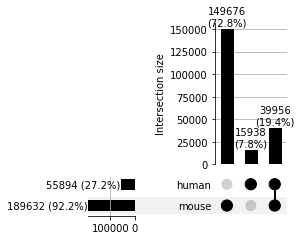

In [78]:

label_dict = {'mouse': plot_df[plot_df.label == 'mouse'].ID.tolist() + plot_df[plot_df.label == 'both'].ID.tolist(),
              'human': plot_df[plot_df.label == 'human'].ID.tolist() + plot_df[plot_df.label == 'both'].ID.tolist()}

plt = UpSet(from_contents(label_dict), 
            subset_size='count', 
            min_subset_size=0 ,
            show_counts=True,
            show_percentages=True).plot()        

The Venn diagram below shows the same as above but in measurment of base pairs. <br>


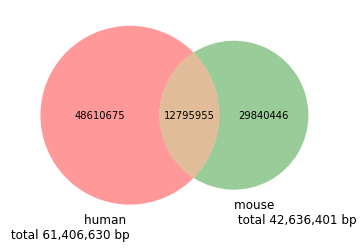

In [74]:

both =  mATAC_hATAC.overlap_len.sum()
men_unique =  (hATAC.TO - hATAC.FROM).sum() - both
mouse_unique = mATAC.length.sum() - both
    
# First way to call the 2 group Venn diagram:
human_label = f'human \n total {both + men_unique:,} bp'
mouse_label = f'mouse \n total {both + mouse_unique:,} bp'
venn2(subsets = (men_unique, mouse_unique, both), set_labels = (human_label, mouse_label))
plt.show()